# ATOC5860 - eof_example_iris - Lecture #6
### commenting and most of the coding by Prof. Jen Kay (University of Colorado)
### inspired by http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html, and https://en.wikipedia.org/wiki/Iris_flower_data_set
### last updated February 16, 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import xarray  #package that open and manipulates netcdf files
import matplotlib.dates as mdates
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import math

%matplotlib inline

In [3]:
## The data are 50 samples each from three species of Iris (Iris setosa, Iris virginica and Iris versicolor). 
## Four traits were measured for every flower: the length and the width of the sepals and petals, in centimetres. 
## Based on these four traits, the scientist working with the data (Fisher) 
## investigated if it was possible to distinguish the species from each other.

### Read in the data
### Data from https://archive.ics.uci.edu/ml/datasets/Iris

### if on the internet you can use this:
#data = pd.read_csv(
#    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
#    header=None,
#    sep=',')

### otherwise download the data to the folder you are running your jupyter notebook in and run this code
data = pd.read_csv('iris.data.csv',
    header=None,
    sep=',')

data.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
data.dropna(how="all", inplace=True) # drops the empty line at file-end

## print a bit about the data
print(np.shape(data))
data.head()
#data.tail()

(150, 5)


,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
### split data into measurements of flower traits (X) and flower class (Y)
X = data.iloc[:,0:4].values
y = data.iloc[:,4].values ### these are the different iris types
print('shape of your data matrix: ',np.shape(X))
##print(y)

shape of your data matrix:  (150, 4)


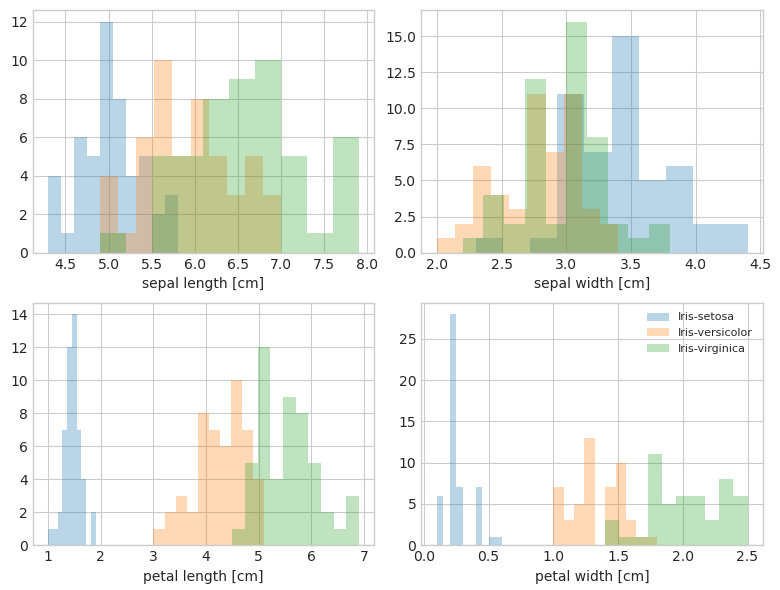

In [5]:
### To get a feeling for how the 3 different flower classes are distributes along the 4 different features, 
### let us visualize them via histograms. (Taken directly from sebastianraschka.com)
label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)
    plt.tight_layout()    

In [6]:
## PREPARE THE DATA FOR EOF ANALYSIS
## standardize the data - remove the mean and divide by the standard deviation
X_stand=(X-np.mean(X,axis=0))/np.std(X,axis=0)

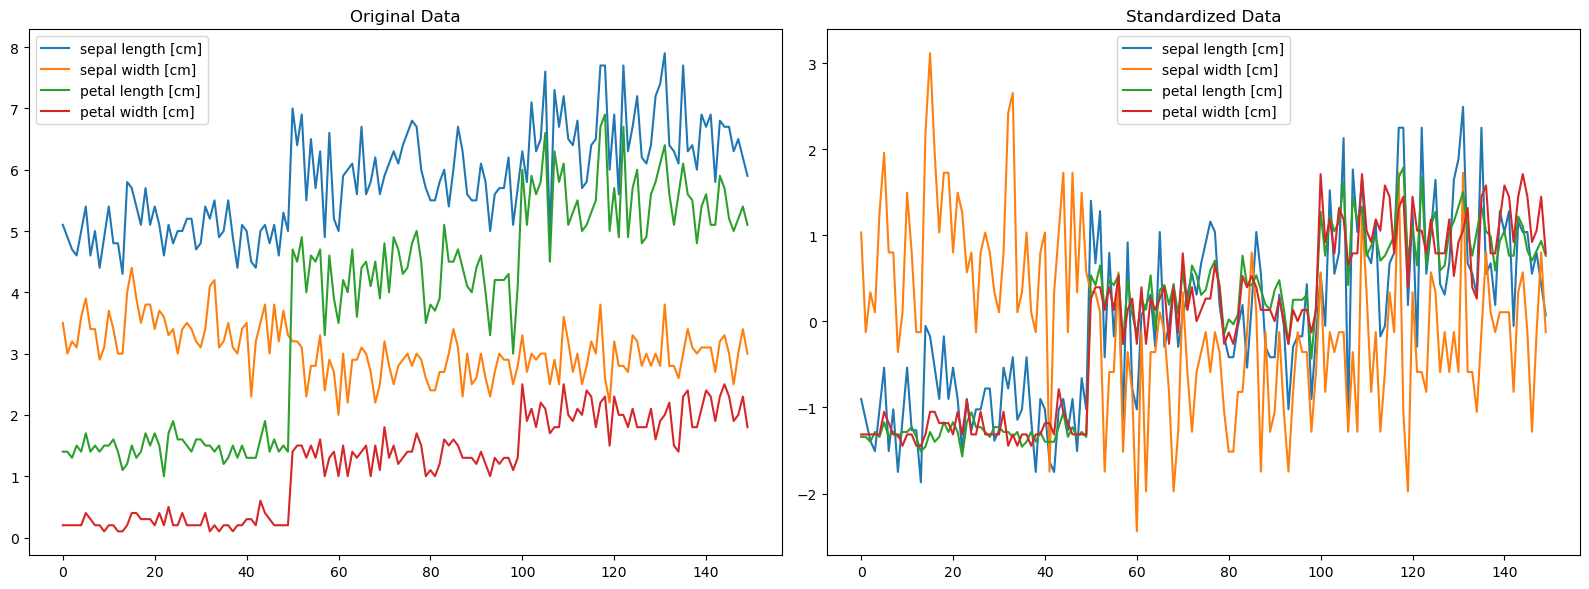

In [7]:
### LOOK AT YOUR DATA
### a very simple look at the data matrix; useful for thinking about what the EOF analysis will give us
### the first 50 samples are iris-setosa, the second 50 samples are iris-versicolor, and the final 50 samples are
### iris-virginica

f=plt.figure(figsize=(16,6));
gs=GridSpec(1,2);
plt.subplot(gs[0,0]);
plt.plot(X[:,0],label=feature_dict[0]);
plt.plot(X[:,1],label=feature_dict[1]);
plt.plot(X[:,2],label=feature_dict[2]);
plt.plot(X[:,3],label=feature_dict[3]);
plt.legend();

plt.title('Original Data');
plt.subplot(gs[0,1]);
plt.plot(X_stand[:,0],label=feature_dict[0]);
plt.plot(X_stand[:,1],label=feature_dict[1]);
plt.plot(X_stand[:,2],label=feature_dict[2]);
plt.plot(X_stand[:,3],label=feature_dict[3]);
plt.legend();
plt.title('Standardized Data');
plt.tight_layout();

### From Barnes CH3 Pg 2:

1.1.5 Covariance and Correlation Matrices. 

If you have a matrix, X, of dimensions M x N and if the columns within X have a mean of zero, then:

$$
C = \frac{1}{M}X^TX
$$

Where C is the covariance matrix of dimensions N x N. 

But if the columns of X are standardized then this is actually the correlation matrix.


### From Barnes CH3 Pg 10:

The equation to obtain lambda and E comes from equation 42 where

$$
Ce_1=e_1\lambda_1
$$

where $e_1$ must be an eigenvector of C with  corresponding eigenvalue $\lambda_1$

In [8]:
### STEP #2 - Calculate the EOFs -- Using eigenanalysis of the covariance matrix (the np.linalg.eig method)

#calculate covariance matrix
C = 1./np.size(X_stand,axis = 0)*np.dot(np.transpose(X_stand),X_stand) ## Barnes Chapter 3 Equation 7
print('shape of data matrix: ',np.shape(X_stand))
print('shape of covariance matrix: ',np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method
lam, E = LA.eig(C) ## Barnes Chapter 3 Equation 42

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

print('Eigenvectors:')
print(E)
print('Eigenvalues:')
print(lam)

shape of data matrix:  (150, 4)
shape of covariance matrix:  (4, 4)
Eigenvectors:
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Eigenvalues:
[2.91081808 0.92122093 0.14735328 0.02060771]


In [9]:
### STEP #2 - Calculate the EOFs -- Using Singular Value Decomposition (SVD) (the np.linalg SVD method)
u,s,v=LA.svd(X_stand)  ## Barnes Chapter 3 Equation (65)
print('Eigenvectors:')
print(u)

Eigenvectors:
[[-1.08374515e-01 -4.30198387e-02  2.59377669e-02 ...  5.42576376e-02
   1.60581494e-03  2.27770498e-03]
 [-9.98503796e-02  5.57547718e-02  4.83370288e-02 ...  5.32189412e-03
   8.56651825e-02  6.44405862e-03]
 [-1.13323362e-01  2.70926177e-02 -1.09498919e-02 ...  2.76010922e-02
   1.78415121e-01  1.49430370e-01]
 ...
 [ 7.27833114e-02 -2.26960075e-02 -3.81328738e-02 ...  9.89545817e-01
  -1.24233079e-02 -6.58105858e-04]
 [ 6.58701606e-02 -8.64611208e-02 -1.98113038e-01 ... -1.40226565e-02
   9.52228601e-01 -2.32385318e-02]
 [ 4.59092965e-02  1.89567788e-03 -1.12476331e-01 ... -7.86338250e-04
  -2.19591161e-02  9.77215825e-01]]


In [10]:
### STEP #3 - Plot the eigenvalues from both methods 

# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))
##print(pve2[0:10]-pve[0:10])

f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,100])
plt.xlim([1,10])
plt.legend()
plt.ylabel('Variance Explained (%)')
plt.xlabel('Eigenvalue')

print('Variance explained by first two eigenvalues (eig):',np.round(pve[0]+pve[1],1))
print('Variance explained by first two eigenvalues (svd):',np.round(pve2[0]+pve2[1],1))

Variance explained by first two eigenvalues (eig): 95.8
Variance explained by first two eigenvalues (svd): 95.8


In [11]:
### STEP 4 - Find the first two EOFs and PCs -- They are explaining most of the variance!

## FIRST ONE
eof_num=1

# Find the eigenvector (e1) associated with eof1 from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with eof1 from the eigenanalysis method
z1 = np.dot(X_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1 {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with eof1 from the SVD method
print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:])
print(f'shape e1_svd: {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with eof1 from the SVD method
z1_svd = u[:,eof_num-1]
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape z1_svd: {np.shape(z1_svd)}')

# select an EOF
eof_num=2

# Find the eigenvector (e2) associated with eof2 from the eigenanalysis method
e2 = E[:,eof_num-1]
#print(np.shape(e2))

# Calculate the principal component (z1) associated with eof2 from the eigenanalysis method
z2 = np.dot(X_stand,e2)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z2 = (z2-np.mean(z2))/np.std(z2)  
#print(np.shape(z2))

# Find the eigenvector (e1_svd) associated with eof2 from the SVD method
#print(np.shape(v),np.shape(s),np.shape(u))
e2_svd = (v[eof_num-1,:])
#print(np.shape(e2_svd))

# Calculate the principal component (z1_svd) associated with eof2 from the SVD method
z2_svd = u[:,eof_num-1] ##*(s[eof_num-1])
## standardize it
z2_svd = (z2_svd-np.mean(z2_svd))/np.std(z2_svd)  
#print(np.shape(z2_svd))

shape of e1 (4,)
shape of z1 (150,)
(4, 4) (4,) (150, 150)
shape e1_svd: (4,)
shape z1_svd: (150,)


In [12]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)
### What can you conclude about the underlying different types of iris?
### remember: the first 50 samples are iris-setosa, the second 50 samples are iris-versicolor, 
### and the final 50 samples are iris-virginica

### My Conclusion: The first class of iris (Iris-setosa, first 50 samples) seems linearly separable 
### from the other classes of iris (Iris-versicolor, Iris-virginica)' based on EOF1/PC1
f=plt.figure(figsize=(12,10));
gs=GridSpec(2,2);
plt.subplot(gs[0,0]);
plt.plot(np.arange(1,5,1),e1);
plt.plot(np.arange(1,5,1),e1_svd,color='r');
plt.xticks(np.arange(1,5,1));
plt.title('EOF1 (e1)');
plt.xlabel('structure dimension',fontsize=12);
plt.subplot(gs[1,0]);
plt.plot(z1);
plt.plot(z1_svd,color='r');
plt.title('PC1 (z1)');
plt.xlabel('sampling dimension',fontsize=12);
plt.subplot(gs[0,1]);
plt.plot(np.arange(1,5,1),e2);
plt.plot(np.arange(1,5,1),e2_svd,color='r');
plt.xticks(np.arange(1,5,1));
plt.title('EOF2 (e2)');
plt.xlabel('structure dimension',fontsize=12);
plt.subplot(gs[1,1]);
plt.plot(z2);
plt.plot(z2_svd,color='r');
plt.title('PC2 (z2)');
plt.xlabel('sampling dimension',fontsize=12);
plt.tight_layout();

In [13]:
## Because the first two eigenvectors explain 95% of the variance... 
## Let's see what happens when we reduce the 4-dimensional original datas to a 2-dimensional data subspace

## Define a matrix with our top two eigenvectors (Esub)
Esub = np.hstack((e1.reshape(4,1),e2.reshape(4,1)))
print(np.shape(Esub))

(4, 2)


In [14]:
##Project the data onto Esub, the matrix with the subset of eigenvectors
Zsub = np.dot(X_stand,Esub)  ## Barnes Equation 50

In [15]:
##Let's predict the original data using only two eigenvectors/PCs
Xsub=np.dot(Zsub,np.transpose(Esub)) ## Barnes Equation (51)
print(np.shape(Xsub))

(150, 4)


In [16]:
## Plot the original data and the data predicted using only the first two EOF/PC
## Wow - They looks similar!
f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0]);
plt.plot(X_stand[:,0],label=feature_dict[0]);
plt.plot(X_stand[:,1],label=feature_dict[1]);
plt.plot(X_stand[:,2],label=feature_dict[2]);
plt.plot(X_stand[:,3],label=feature_dict[3]);
plt.title('Original Data');
plt.subplot(gs[0,1]);
plt.plot(Xsub[:,0],label=feature_dict[0]);
plt.plot(Xsub[:,1],label=feature_dict[1]);
plt.plot(Xsub[:,2],label=feature_dict[2]);
plt.plot(Xsub[:,3],label=feature_dict[3]);
plt.title('Data Predicted using first two EOF/PC');
plt.tight_layout();

In [17]:
## Make a scatter plot of principal component #1 vs. principal component #2
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Zsub[y==lab, 0],
                    Zsub[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()